In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/signlangdata.zip','r') as zip:
  zip.extractall()


In [3]:
! pip install keras


In [4]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


**Sample image display**

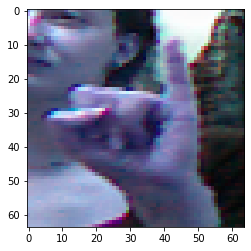

In [13]:

img_arr=cv2.imread('/content/dataset5/C/i/color_8_0027.png',cv2.IMREAD_COLOR)
img=cv2.resize(img_arr,(64,64))
plt.imshow(img)


In [16]:
import glob

def get_labels_images(filepath):
    data_dict = {}
    for directory in glob.glob(filepath):
        images = []
        for file in glob.glob(directory+'/color_*.png'):
            images.append(file)
        data_dict.setdefault(directory[-1], images)
        
    return data_dict

dataset=os.path.abspath('/content/dataset5/*/*')
data_dict=get_labels_images(dataset)

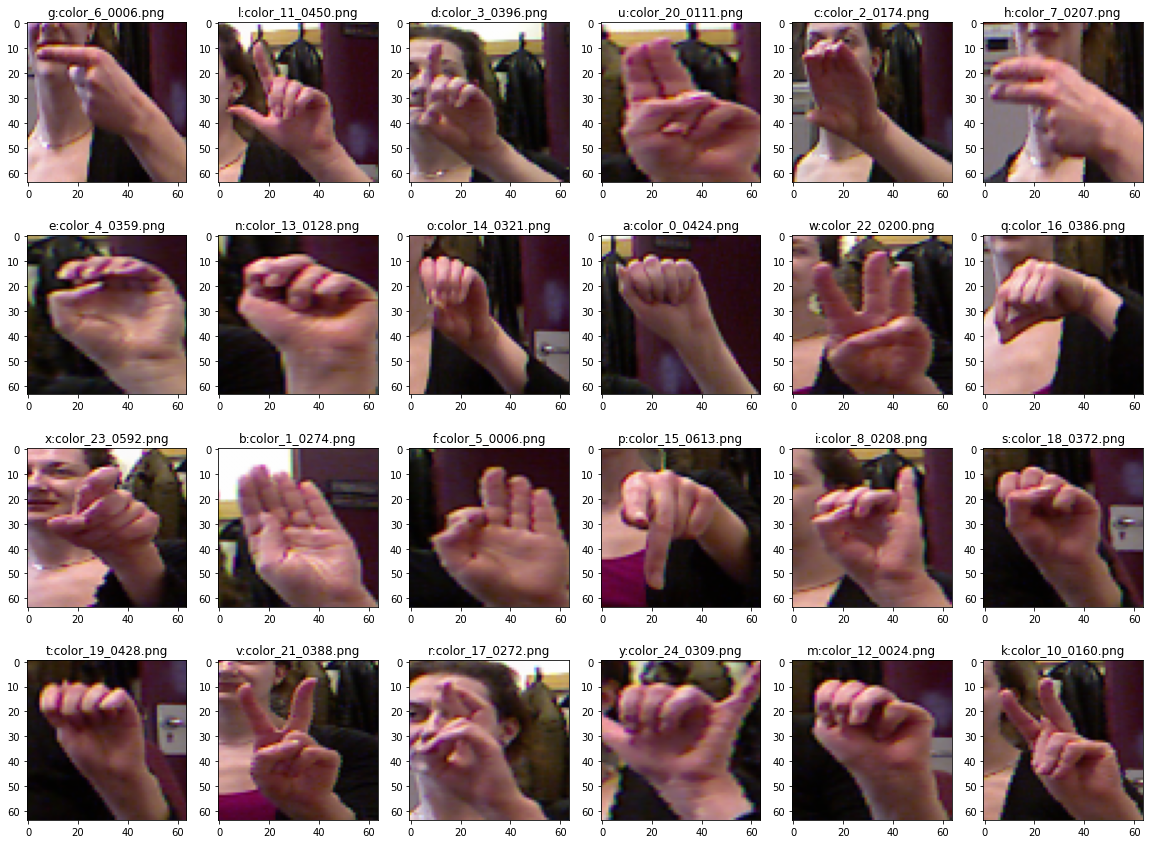

In [21]:
plt.figure(figsize = (20,15))

for i, (k,v) in enumerate(data_dict.items()):
    img = cv2.imread(v[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    img=img/255.
    plt.subplot(4,6,i+1)
    plt.imshow(img)
    plt.title(k + ":" + os.path.basename(v[0]))
    
plt.show()

# Pre-processing Images

In [22]:
def preprocess(dictionary):
  images=[]
  labels=[]
  for k,v in dictionary.items():
    for i in v:
      img=cv2.imread(i)
      img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img=cv2.resize(img,(64,64))
      img=img/255.
      images.append(img)
      labels.append(k)
  return (np.array(images), np.array(labels).reshape(-1,1))   

images, labels=preprocess(data_dict)

In [24]:
from sklearn import preprocessing
label_encoding=preprocessing.LabelBinarizer()
labels=label_encoding.fit_transform(labels)